# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        mouse_defs = params.mouse_defs
        defs = mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
    finally:
        os.chdir(nbPath)
    
    
    %run "S1-mouse-M1-decoding.ipynb"
    
    print('Done!')

Done!


# Part 1

functions that plot each panel.


In [2]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---

In [3]:
@utility.report
def plot_m1_decoding(ax, AllDFs):
    defs = mouse_defs

    reg_scores = []
    for i, df in enumerate(AllDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[0],
                                                      n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        _,_,n_trial,n_time,n_comp = AllData.shape
        half_trials = int(n_trial /2)
        AllData1 = AllData[0,...][:,:half_trials, :,:]
        AllData2 = AllData[0,...][:,-half_trials:,:,:]
        AllVel1 = AllVel[0,...][:,:half_trials, :,:]
        AllVel2 = AllVel[0,...][:,-half_trials:,:,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))

        # train the decoder
        Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
        Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]
        x_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=10).mean()
        y_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=10).mean()
        z_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_z,Y_test_z)),scoring=defs.custom_r2_scorer, cv=10).mean()
        reg_scores.append((i,(x_score,y_score,z_score)))
    pop_score_day = []
    for _,scores in reg_scores:
        pop_score_day.append(np.mean(scores))
    pop_score_day = np.array(pop_score_day)


    #=========================
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # train the decoder
        *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_scores_across.append((id1,testId,(x_score,y_score,z_score)))
    pop_score_across = []
    for _,_,scores in reg_scores_across:
        pop_score_across.append(np.mean(scores))
    pop_score_across = np.array(pop_score_across)

    #================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape, AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # train the decoder
        U,V = X1[goodIndex,:], X2[goodIndex,:]
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_latent_scores.append((id1,testId,(x_score,y_score,z_score)))
    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)



#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label='Across\n' r'(\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label='Across\n' r'(\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density', labelpad=1)
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_m1_decoding(ax, allDFs_M1)
    
    plt.show()

# Part 2

Plot figure

Executed: `get_full_mouse_data` in 1.0s
Executed: `plot_m1_decoding` in 6.6s


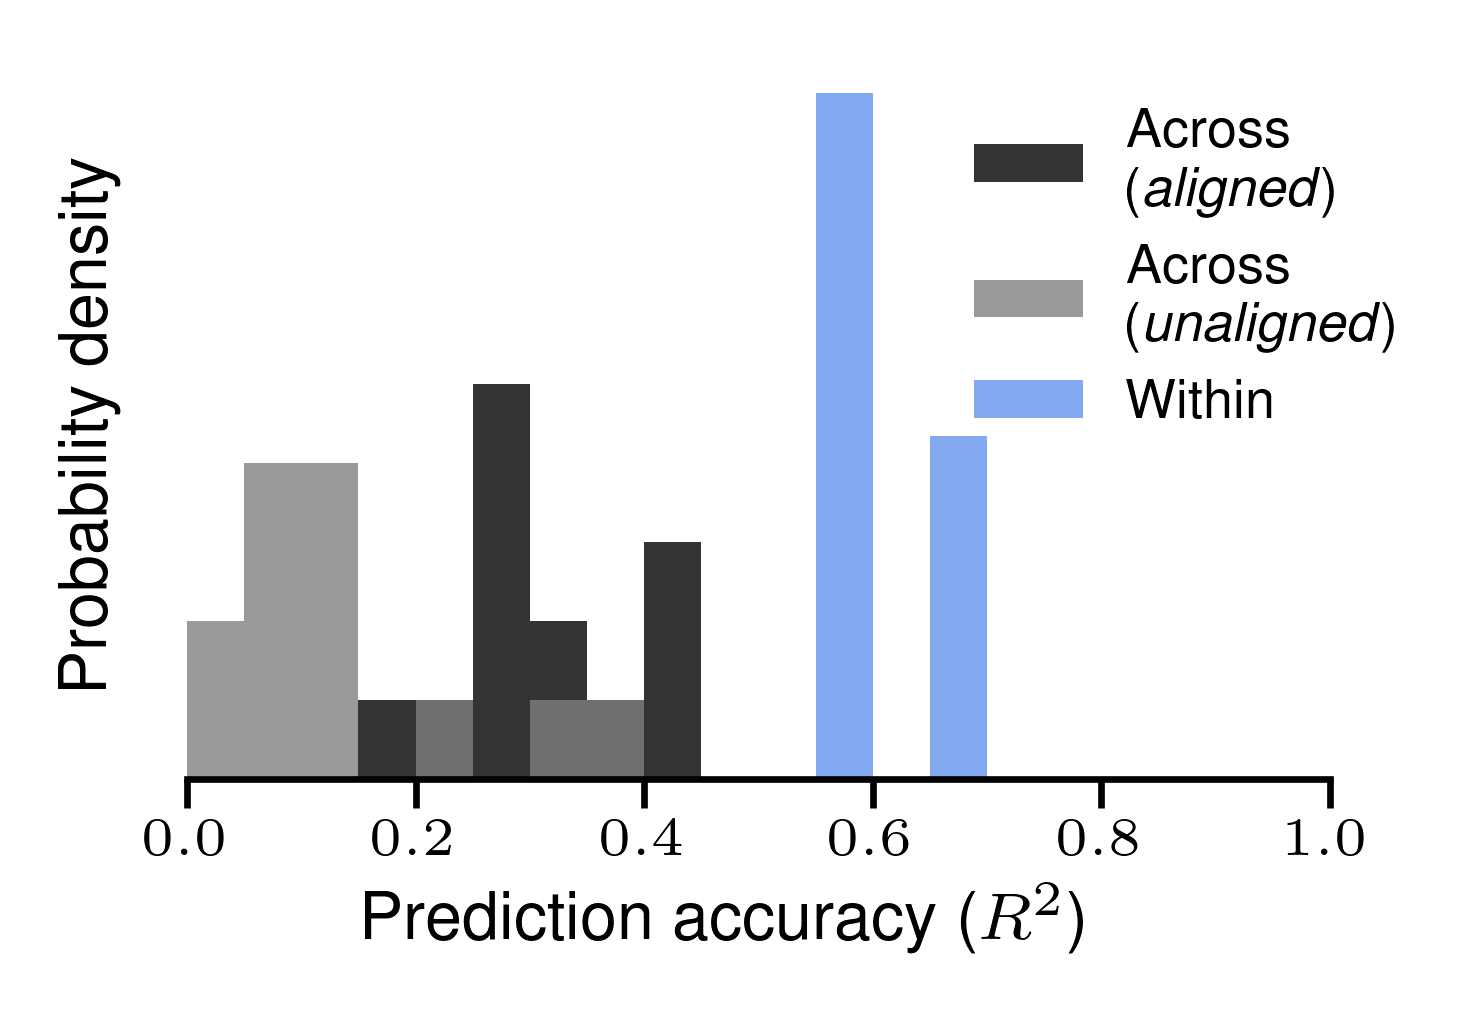

In [5]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= params.panels.decoding_hist
    fig=plt.figure(figsize=figsize)
    
   
    
    ##########################################
    # 1: Decoding for mouse M1
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=figsize[0],
                                    right=figsize[1],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax1 = fig.add_subplot(gs1[0])

       
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_m1_decoding(ax1, allDFs_M1)


    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
#     OFFX=np.array([.02]*len(AXES))
#     OFFY=np.array([.03]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
#     params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS1-mouse-M1-decoding.pdf', format='pdf', bbox_inches='tight')